<a href="https://colab.research.google.com/github/essy1994/essy1994/blob/master/JointmBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !nvidia-smi

In [ ]:
!pip install seqeval -qqq
# TODO: update this notebook to work with the latest version of transformers
!pip install -q transformers==2.11.0

     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 674 kB 25.1 MB/s 
     |████████████████████████████████| 880 kB 61.2 MB/s 
     |████████████████████████████████| 7.5 MB 60.7 MB/s 
     |████████████████████████████████| 1.3 MB 62.2 MB/s 


In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

#Importing Libraries

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, TensorBoard
from seqeval.metrics import classification_report
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import shutil
import pickle
from seqeval.metrics import classification_report

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score

#Loading Data

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/JP Morgan/Data/translated_set/corrected slot labels data/translated_swa_test_slot_labels.xlsx")

In [ ]:
df.shape

(893, 6)

In [ ]:
df.head(2)

,utterance,slot_labels,intent,utterance_swa,slot_labels_swa,intent_swa
0,what are the flights from tacoma to miami that...,O O O O O B-fromloc.city_name O B-toloc.city_n...,flight,ni safari gani za ndege kutoka tacoma hadi mia...,O O O O O O B-kutoka_mji_jina O B-hadi_mji_jin...,ndege
1,what flights arrive at love field on june sixth,O O O O B-toloc.airport_name I-toloc.airport_n...,flight,ni ndege gani zinazofika kwenye uwanja wa love...,O O O O O O O B-hadi_uwanja_wa_ndege_jina I-ha...,ndege


In [ ]:
df.rename(columns = {'utterance_swa	':'words','slot_labels_swa':'word_labels','intent_swa':'intent_label'}, inplace = True)

In [ ]:
# df.head(2)

In [ ]:
df["words"] = df["utterance_swa"]
del df["utterance_swa"]
df.head(2)

,utterance,slot_labels,intent,word_labels,intent_label,words
0,what are the flights from tacoma to miami that...,O O O O O B-fromloc.city_name O B-toloc.city_n...,flight,O O O O O O B-kutoka_mji_jina O B-hadi_mji_jin...,ndege,ni safari gani za ndege kutoka tacoma hadi mia...
1,what flights arrive at love field on june sixth,O O O O B-toloc.airport_name I-toloc.airport_n...,flight,O O O O O O O B-hadi_uwanja_wa_ndege_jina I-ha...,ndege,ni ndege gani zinazofika kwenye uwanja wa love...


In [ ]:
# df.head(2)

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2)

In [ ]:
df_train.head(2)

,utterance,slot_labels,intent,word_labels,intent_label,words
344,flights newark to los angeles wednesday morning,O B-fromloc.city_name O B-toloc.city_name I-to...,flight,O O O B-kutoka_mji_jina O B-hadi.mji_jina I-ha...,ndege,safari za ndege newark hadi los angeles jumata...
598,show me a return flight from miami to jfk please,O O O B-round_trip O O B-fromloc.city_name O B...,flight,O O O B-safari_ya_kurudi O B-kutoka_mji_jina O...,ndege,nionyeshe ndege ya kurudi kutoka miami hadi jf...


In [ ]:
df_valid.head(2)

,utterance,slot_labels,intent,word_labels,intent_label,words
333,kansas city to atlanta monday morning flights,B-fromloc.city_name I-fromloc.city_name O B-to...,flight,B-kutoka_mji_jina I-kutoka_mji_jina O B-hadi.m...,ndege,kansas city hadi atlanta jumatatu asubuhi safa...
775,list all flights arriving in denver between 8 ...,O O O O O B-toloc.city_name O B-arrive_time.st...,flight,O O O O B-hadi.mji_jina O O B-kufika_muda.kuan...,ndege,orodhesha ndege zote zinazowasili denver kati ...



## A First Model: Intent Classification (Sentence Level)

Let's ignore the slot filling task for now and let's try to build a sentence level classifier by fine-tuning a pre-trained Transformer-based model using the `huggingface/transformers` package that provides both TF2/Keras and Pytorch APIs.

### The BERT Tokenizer

First let's load a pre-trained tokenizer and test it on a test sentence from the training set:

In [ ]:
from transformers import BertTokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

ModuleNotFoundError: ignored

#Testing word tokenization using Bert

In [ ]:
first_sentence = df_train.iloc[0]["words"]
first_sentence

'safari za ndege newark hadi los angeles jumatano asubuhi'

In [ ]:
encoding = tokenizer.encode(first_sentence)
print(tokenizer.convert_ids_to_tokens(encoding))

['[CLS]', 'sa', '##fari', 'za', 'nde', '##ge', 'new', '##ark', 'hadi', 'los', 'ang', '##eles', 'ju', '##matan', '##o', 'asub', '##uh', '##i', '[SEP]']


It can be noticed that BERT uses subword tokens so the length of the tokenized sentence is likely to be larger than the number of words in the sentence.


Remarks:

- The first token `[CLS]` is used by the pre-training task for sequence classification.
- The last token `[SEP]` is a separator for the pre-training task that classifiies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).

#Data Preprocessing

Checking the length of sequences after tokenization, so that we could assign them to equal dummy vectors in the training set

Text(0.5, 1.0, 'max sequence length: 55')

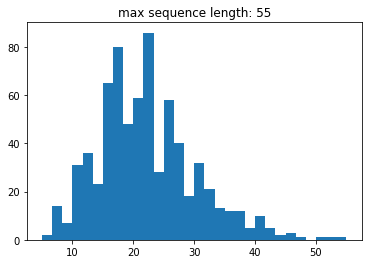

In [ ]:
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}")

[link text](https://)The mapping can be introspected in the `tokenizer.vocab` attribute:

### Encoding the Dataset with the Tokenizer

Encoding the full train / valid and test sets with Bert tokenizer to get a padded integer numpy arrays:

In [ ]:
import numpy as np

def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

encoded_train = encode_dataset(tokenizer, df_train["words"], 60)
encoded_train["input_ids"]

array([[   101,  10148, 110066, ...,      0,      0,      0],
       [   101,  10414,  16131, ...,      0,      0,      0],
       [   101,  14441,  73840, ...,      0,      0,      0],
       ...,
       [   101,  10414,  23105, ...,      0,      0,      0],
       [   101,  10153,  61478, ...,      0,      0,      0],
       [   101,  23105,  10525, ...,      0,      0,      0]], dtype=int32)

In [ ]:
encoded_train["attention_masks"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], 60)
# encoded_test = encode_dataset(tokenizer, df_test["words"], 90)

### Encoding the Sequence Classification Targets

To do so we build a simple mapping from the auxiliary files:

In [ ]:
seq_out_tokenizer = Tokenizer(filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n', oov_token="UNK",lower=False)

In [ ]:
##Preprocessing

df_train.fillna('O',inplace = True)

df_valid.fillna('O',inplace = True)

In [ ]:
seq_out_tokenizer.fit_on_texts(df_train["word_labels"].tolist())

In [ ]:
seq_out_tokenizer.fit_on_texts(df_valid["word_labels"].tolist())

In [ ]:
seq_out_word_to_index = seq_out_tokenizer.word_index
len(seq_out_word_to_index)

140

In [ ]:
seq_out_word_to_index

{'UNK': 1,
 'O': 2,
 'B-hadi.mji_jina': 3,
 'B-kutoka_mji_jina': 4,
 'I-hadi.mji_jina': 5,
 'B-kuondoka_terehe.siku_jina': 6,
 'I-kutoka_mji_jina': 7,
 'B-kuondoka_muda.kipindi_cha_siku': 8,
 'B-ndege_jina': 9,
 'I-safari_ya_kurudi': 10,
 'B-kutoka.mji_jina': 11,
 'B-hadi_mji_jina': 12,
 'I-kufika_muda.muda': 13,
 'B-ndege_kanuni': 14,
 'I-kuondoka_muda.muda': 15,
 'I-ndege_jina': 16,
 'B-safari_ya_kurudi': 17,
 'B-mji_jina': 18,
 'B-kuondoka_muda.muda_jamaa': 19,
 'B-kuondoka_muda.muda': 20,
 'B-kufika_muda.muda': 21,
 'B-kuondoka_tarehe.siku_jina': 22,
 'I-ndege_acha': 23,
 'B-gharama_jamaa': 24,
 'I-hadi_mji_jina': 25,
 'I-kategoria_aina': 26,
 'I-gharama_jamaa': 27,
 'I-kuondoka_terehe.siku_nambari': 28,
 'B-chakula_nambari': 29,
 'I-kutoka.mji_jina': 30,
 'B-ndege_mod': 31,
 'B-ndege_acha': 32,
 'I-mji_jina': 33,
 'B-kufika_muda.muda_jamaa': 34,
 'B-kategoria_aina': 35,
 'I-uchumi': 36,
 'B-kuondoka_terehe.mwezi_jina': 37,
 'B-kuondoka_terehe.siku_nambari': 38,
 'I-kuondoka_tarehe

In [ ]:
intent_names = set(df_train.intent_label)
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'ndege_nambari#atis_shirika_la_ndege': 0,
 'Ndege': 1,
 'mlo': 2,
 'mji': 3,
 'muda_wa_ndege': 4,
 'nauli_ya_ndege': 5,
 'nauli_ya_ndege#atis_ndege': 6,
 'shirika_la_ndege': 7,
 'uwezo': 8,
 'nauli_ya_ardhini': 9,
 'uwanja_wa_ndege': 10,
 'ndege#atis_nauli_ya_ndege': 11,
 'umbali': 12,
 'kiasi': 13,
 'huduma_ya_ardhini': 14,
 'siku_jina': 15,
 'ndege_nambari': 16,
 'ufupisho': 17,
 'ndege': 18}

In [ ]:
intent_train = df_train["intent_label"].map(intent_map).values

In [ ]:
intent_valid = df_valid["intent_label"].map(intent_map).values

### Loading and Feeding a Pretrained BERT model

Loading a pretrained BERT Large model using the [huggingface transformers](https://github.com/huggingface/transformers) package:

In [ ]:
from transformers import TFAutoModel

large_bert_model = TFAutoModel.from_pretrained("bert-base-multilingual-cased")
large_bert_model.summary()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
Total params: 177,853,440
Trainable params: 177,853,440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_valid

{'input_ids': array([[   101,  81212,  10403, ...,      0,      0,      0],
        [   101,  16002,  20193, ...,      0,      0,      0],
        [   101,  62137,  10213, ...,      0,      0,      0],
        ...,
        [   101,  13587, 100962, ...,      0,      0,      0],
        [   101,  12411,  86267, ...,      0,      0,      0],
        [   101,  62137,  10213, ...,      0,      0,      0]], dtype=int32),
 'attention_masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)}

In [ ]:
outputs = large_bert_model(encoded_valid)
len(outputs)

2

The **first ouput** of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence**:

In [ ]:
outputs[0].shape

TensorShape([179, 60, 768])

The **second output** of the BERT model is a tensor with shape `(batch_size, output_dim)` which is the vector representation of the special token `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**.

In [ ]:
outputs[1].shape

TensorShape([179, 768])

#Mapping slots to the corresponding indexes

In [ ]:
slot_names = ["[PAD]"]
slot_names += list(seq_out_word_to_index.keys())[1:]
slot_names

['[PAD]',
 'O',
 'B-hadi.mji_jina',
 'B-kutoka_mji_jina',
 'I-hadi.mji_jina',
 'B-kuondoka_terehe.siku_jina',
 'I-kutoka_mji_jina',
 'B-kuondoka_muda.kipindi_cha_siku',
 'B-ndege_jina',
 'I-safari_ya_kurudi',
 'B-kutoka.mji_jina',
 'B-hadi_mji_jina',
 'I-kufika_muda.muda',
 'B-ndege_kanuni',
 'I-kuondoka_muda.muda',
 'I-ndege_jina',
 'B-safari_ya_kurudi',
 'B-kuondoka_muda.muda_jamaa',
 'B-mji_jina',
 'B-kuondoka_muda.muda',
 'B-kuondoka_tarehe.siku_jina',
 'B-kufika_muda.muda',
 'I-ndege_acha',
 'B-gharama_jamaa',
 'I-hadi_mji_jina',
 'I-kategoria_aina',
 'I-gharama_jamaa',
 'I-kuondoka_terehe.siku_nambari',
 'I-kutoka.mji_jina',
 'B-chakula_nambari',
 'B-ndege_mod',
 'B-ndege_acha',
 'I-mji_jina',
 'B-kategoria_aina',
 'B-kufika_muda.muda_jamaa',
 'I-uchumi',
 'B-kuondoka_terehe.mwezi_jina',
 'B-kuondoka_terehe.siku_nambari',
 'I-kuondoka_tarehe.siku_nambari',
 'B-kuondoka_tarehe.siku_nambari',
 'B-msimbo_msingi_wa_nauli',
 'B-kuondoka_tarehe.mwezi_jina',
 'I-kuondoka_muda.kipindi_ch

In [ ]:
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
slot_map

{'[PAD]': 0,
 'O': 1,
 'B-hadi.mji_jina': 2,
 'B-kutoka_mji_jina': 3,
 'I-hadi.mji_jina': 4,
 'B-kuondoka_terehe.siku_jina': 5,
 'I-kutoka_mji_jina': 6,
 'B-kuondoka_muda.kipindi_cha_siku': 7,
 'B-ndege_jina': 8,
 'I-safari_ya_kurudi': 9,
 'B-kutoka.mji_jina': 10,
 'B-hadi_mji_jina': 11,
 'I-kufika_muda.muda': 12,
 'B-ndege_kanuni': 13,
 'I-kuondoka_muda.muda': 14,
 'I-ndege_jina': 15,
 'B-safari_ya_kurudi': 16,
 'B-kuondoka_muda.muda_jamaa': 17,
 'B-mji_jina': 18,
 'B-kuondoka_muda.muda': 19,
 'B-kuondoka_tarehe.siku_jina': 20,
 'B-kufika_muda.muda': 21,
 'I-ndege_acha': 22,
 'B-gharama_jamaa': 23,
 'I-hadi_mji_jina': 24,
 'I-kategoria_aina': 25,
 'I-gharama_jamaa': 26,
 'I-kuondoka_terehe.siku_nambari': 27,
 'I-kutoka.mji_jina': 28,
 'B-chakula_nambari': 29,
 'B-ndege_mod': 30,
 'B-ndege_acha': 31,
 'I-mji_jina': 32,
 'B-kategoria_aina': 33,
 'B-kufika_muda.muda_jamaa': 34,
 'I-uchumi': 35,
 'B-kuondoka_terehe.mwezi_jina': 36,
 'B-kuondoka_terehe.siku_nambari': 37,
 'I-kuondoka_tareh

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word:

In [ ]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,max_length):
  
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, 60)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 60)
# slot_test = encode_token_labels(
#     df_test["words"], df_test["word_labels"], tokenizer, slot_map, 90)

In [ ]:
########################
######### Debbuging proccess

slot_train[0]

array([  0,  20,  20,  20,   7,  42,  42, 113, 114, 114, 114, 114,   1,
         1,  10,   1,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
slot_valid[0]

array([ 0,  1,  1,  1,  1,  1,  1,  3,  6,  6,  6,  1,  1,  1,  2,  4,  5,
        5,  5,  7, 42,  1,  1, 29, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
# slot_map

In [ ]:
# # def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,max_length):

# text_sequences = df_train["words"]
# slot_names = df_train["word_labels"]
# slot_map = slot_map
# max_length  = 63

# encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
# for i, (text_sequence, word_labels) in enumerate(
#         zip(text_sequences, slot_names)):
#     encoded_labels = []

#     for word, word_label in zip(text_sequence.split(), word_labels.split()):

#         tokens = tokenizer.tokenize(word)
#         # print(word_label)

#         encoded_labels.append(slot_map[word_label])

#         expand_label = word_label.replace("B-", "I-")

#         if not expand_label in slot_map:

#             expand_label = word_label
#         encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
#     encoded[i, 1:len(encoded_labels) + 1] = encoded_labels

# # print(encoded)

# slot_train = encode_token_labels(
#     df_train["words"], df_train["word_labels"], tokenizer, slot_map, 63)
# slot_valid = encode_token_labels(
#     df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 63)
# slot_test = encode_token_labels(
#     df_test["words"], df_test["word_labels"], tokenizer, slot_map, 63)

In [ ]:
# df_train["words"][0]

In [ ]:
# df_train["word_labels"][0]

In [ ]:
slot_map['O']

1

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions recieve a 0 label.

#Joint Intent And Slot Filling Model

In [ ]:
class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-multilingual-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, training=False):
        sequence_output, pooled_output = self.bert(inputs, training=training)

        # The first output of the main BERT layer has shape:
        # (batch_size, max_length, output_dim)
        sequence_output = self.dropout(sequence_output, training=training)
        slot_logits = self.slot_classifier(sequence_output)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output, training=training)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits

joint_model = JointIntentAndSlotFillingModel(intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))
        
# joint_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),loss=losses)


In [ ]:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [ ]:
#########

# checkpoint_path = "/content/drive/MyDrive/JP Morgan/Data/model_ester_swa/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

In [ ]:
#### Loading Model weights for training 

################

# joint_model.load_weights('/content/drive/MyDrive/JP Morgan/Data/model_ester_swa/cp.ckpt')

In [ ]:
history = joint_model.fit(
    encoded_train,
    (slot_train, intent_train),
    validation_data=(encoded_valid, (slot_valid, intent_valid)), 
    epochs=15,
    batch_size=8
)

Epoch 1/15
90/90 [==============================] - 16s 177ms/step - loss: 1.5449 - output_1_loss: 0.4974 - output_2_loss: 1.0475 - output_1_accuracy: 0.9021 - output_2_accuracy: 0.7339 - val_loss: 1.2495 - val_output_1_loss: 0.4143 - val_output_2_loss: 0.8352 - val_output_1_accuracy: 0.9227 - val_output_2_accuracy: 0.7821
Epoch 2/15
90/90 [==============================] - 16s 177ms/step - loss: 1.0740 - output_1_loss: 0.3977 - output_2_loss: 0.6763 - output_1_accuracy: 0.9228 - output_2_accuracy: 0.8333 - val_loss: 1.0894 - val_output_1_loss: 0.3569 - val_output_2_loss: 0.7326 - val_output_1_accuracy: 0.9313 - val_output_2_accuracy: 0.8156
Epoch 3/15
90/90 [==============================] - 16s 179ms/step - loss: 0.8450 - output_1_loss: 0.3515 - output_2_loss: 0.4935 - output_1_accuracy: 0.9304 - output_2_accuracy: 0.8852 - val_loss: 0.9142 - val_output_1_loss: 0.3243 - val_output_2_loss: 0.5898 - val_output_1_accuracy: 0.9339 - val_output_2_accuracy: 0.8436
Epoch 4/15
90/90 [=======

### Save the model

In [ ]:
model = joint_model

model.save("/content/drive/MyDrive/JP Morgan/Data/model_ester_swa/best_working")

#Making prediction on a single text sequence and displaying both the sequence-wise and the token-wise class labels

In [ ]:
def show_predictions(text, tokenizer, model, intent_names, slot_names):

    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    # print(inputs)
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    # print(outputs)
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    # print(slot_ids)
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    intent = [k for k, v in intent_names.items() if v == intent_id]

    # print(slot_ids)

    # print("## Intent:", intent)
    # print("## Slots:")
    slot_pred = []
    
    ####
    text_split = text.split(' ')
    tokens_ids = [(i,j) for i,j in zip(tokenizer.tokenize(text),slot_ids)]
    #### Removing ## Tokens
    tokens_ids_ = [x for x in tokens_ids if not '##' in x[0]]


    for token, slot_id in zip(text_split, tokens_ids_):
      slot_pred.append(slot_names[slot_id[1]])

    return intent, slot_pred

In [ ]:
# slot_names

In [ ]:
df_valid.iloc[55]["words"], df_valid.iloc[55]["word_labels"]

('ni ndege gani huondoka kutoka baltimore na kufika san francisco siku ya Ijumaa',
 'O O O B-kutoka_mji_jina O B-hadi_mji_jina O O B-chakula_nambari O B-ndege_jina')

In [ ]:
pred_intent, pred_slot = show_predictions(df_valid.iloc[0]["words"], tokenizer, joint_model, intent_map, slot_names)
pred_intent, pred_slot

(['ndege'],
 ['O',
  'O',
  'O',
  'O',
  'B-kutoka_mji_jina',
  'I-kutoka_mji_jina',
  'I-kutoka_mji_jina',
  'O',
  'B-hadi.mji_jina',
  'B-hadi.mji_jina',
  'B-kuondoka_terehe.siku_jina',
  'B-kuondoka_muda.kipindi_cha_siku',
  'O',
  'O'])

In [ ]:

# # def evaluate()
#       print(idx, len(true_label), len(pred_slot), len(df_valid.iloc[idx]["words"].split()))
#       print("Added", num_add, ["PAD"]*num_add)
#       print(df_valid.iloc[idx]["words"])
#       print(true_label)
#       print(pred_slot)
#       # break


In [ ]:
# pred_slot
from sklearn.metrics import f1_score

avg_f1_score = []
avg_accuracy_score = []

count = 0

for idx in range(len(df_valid)):
  try:
    pred_intent, pred_slot = show_predictions(df_valid.iloc[idx]["words"], tokenizer, joint_model, intent_map, slot_names)

    true_label = df_valid.iloc[idx]["word_labels"].split()

    # if(len(true_label) > len(pred_slot)):
    #   num_add = len(true_label) - len(pred_slot)
    #   pred_slot.extend(["[PAD]"]*num_add)
    #   count += 1

    # elif(len(pred_slot) > len(true_label)):
    #   num_add = len(pred_slot) - len(true_label)
    #   pred_slot.extend(["O"]*num_add)
    #   count += 1

    f1 = f1_score(true_label, pred_slot, average="macro")
    accuracy = accuracy_score(true_label, pred_slot)

    avg_f1_score.append(f1)
    avg_accuracy_score.append(accuracy)

    # print(len(df_valid.iloc[idx]["word_labels"].split()), len(pred_slot))

  except:
    pass
    # print(idx)
    # print(df_valid.iloc[idx]["words"])
    # print(df_valid.iloc[idx]["word_labels"].split())
    # print(pred_slot)
    # print(len(df_valid.iloc[idx]["word_labels"].split()), len(pred_slot))
    # break
# df_valid.iloc[0]["word_labels"].split(" "), pred_slot

In [ ]:
print("F1 Score: ", np.mean(avg_f1_score), "\nAccuracy:", np.mean(avg_accuracy_score))

F1 Score:  0.7492170157204592 
Accuracy: 0.8881970588779987


In [ ]:
print(count), len(df_valid)

23


(None, 179)

In [ ]:
a = ['O', 'O', 'O', 'O', 'B-safari_kurudi', 'I-safari_kurudi', 'I-safari_kurudi', 'O', 'B-kutoka.mji_jina', 'B-kuondoka_tarehe.siku_jina', 'B-kuondoka_tarehe.tarehe_jamaa', 'O', 'O', 'B-hadi.mji_jina', 'O', 'O', 'B-kufika_muda.muda', 'I-kufika_muda.muda', 'I-kufika_muda.muda', 'B-kufika_muda.kipindi_cha_siku']
b = ['O', 'O', 'O', 'O', 'B-safari_ya_kurudi', 'I-safari_kurudi', 'I-safari_kurudi', 'O', 'B-kutoka.mji_jina', 'B-kuondoka_tarehe.siku_jina', 'B-kuondoka_tarehe.tarehe_jamaa', 'O', 'O', 'B-hadi.mji_jina', 'O', 'O', 'B-kufika_muda.muda', 'I-kufika_muda.muda', 'I-kufika_muda.muda', 'I-kufika_muda.muda']

f1_score(a, b, average="micro")

0.9

In [ ]:
len(df_valid)

179

In [ ]:
# O O O O B-kuva.umujyi_izina B-igihe_umunsi I-igihe_umunsi O B-kugera.umujyi_izina O   B-igihe_umunsi

In [ ]:
show_predictions("kwerekana indege kuva burbank kuri st. louis on monday",
                 tokenizer, joint_model, intent_map, slot_names)

(['ndege'],
 ['O',
  'O',
  'O',
  'B-hadi.mji_jina',
  'O',
  'B-hadi.mji_jina',
  'I-kutoka_mji_jina',
  'I-hadi.mji_jina',
  'O'])

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline
# model_name = 'mbeukman/xlm-roberta-base-finetuned-ner-kinyarwanda'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForTokenClassification.from_pretrained(model_name)

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# example = "Ambasaderi wa EU mu Rwanda , Nicola Bellomo yagize ati “ Inkunga yacu ni imwe mu nkunga yagutse yiswe # TeamEurope ."

# ner_results = nlp(example)
# print(ner_results)

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline

# tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
# model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# example = "My name is Wolfgang and I live in Berlin"

# ner_results = nlp(example)
# print(ner_results)

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline
# model_name = 'mbeukman/xlm-roberta-base-finetuned-kinyarwanda-finetuned-ner-kinyarwanda'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForTokenClassification.from_pretrained(model_name)

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# example = "Ambasaderi wa EU mu Rwanda , Nicola Bellomo yagize ati “ Inkunga yacu ni imwe mu nkunga yagutse yiswe # TeamEurope ."

# ner_results = nlp(example)
# print(ner_results)


In [ ]:
# XLM and roberta